# Задача

   Допустим, на некоторой бирже можно торговать валюты A, B, C и D. Пусть мы также можем
допускать любое отрицательное количество данных валют. В каждом из трех файлов (data1.csv, data2.csv, data3.csv) 
содержатся цены шести инструментов: AB, AC, AD, BC, BD и CD. На каждом тике можно покупать или продавать не более
1 A для инструментов AB, AC, AD; не более 1 B для инструментов BC, BD; не более 1 C для инструмента CD.
Комиссии для инструментов AB, AC, AD платятся в валюте А, комиссии для инструментов BC, BD платятся в валюте B, комиссия для инструмента CD платится в валюте С.

Для примера рассмотрим инструмент AB. Допустим в некоторый момент цена AB равна 5
и комиссия равна 0.1 процента. Это означает, что на каждом тике по указанной цене можно
купить 1 А за 5 B и заплатить комиссию 0.001 A. Либо можно продать 1 А, получить за это 5
B и заплатить комиссию 0.001 A.

Задача. Предположим, что в начале и в конце торговли на нашем счету должно быть нулевое
количество валют B, C и D. Желательно, чтобы в процессе торговли максиальная просадка
были заметно меньше заработка.
Предложить алгоритм, который позволит заработать как можно больше валюты А на предложенных данных, в предположении, что замена данных на статистически аналогичные не
изменит результат работы алгоритма.
Задачу предполагается сделать для двух случаев: комиссия равна нулю и комиссия равна 0.1
проценту.

Подсказка. Максимальный теоретический (статистически стабильный) профит для данных
data1.csv равен (нулевые комиссии: 105 А, комиссия 0.1 процент: 52 А), для данных data2.csv
равен (нулевые комиссии: 163 А, комиссия 0.1 процент: 81 А), для данных data3.csv не указан.
Эти числа даны для ориентировки и могут быть достигнуты только если знать как именно
были сгенерированы данные. Для реального алгоритма заработки будут меньше.

# Идея решения

Рассмотрим для простоты случай с тремя валютами A , B и C.
Эту тройку валют очевидно можно изобразить в виде графа с вершинами A , B и C. 

Запись типа A -> B -> C -> A (обход графа) будет означать что мы меняем некоторое количество валюты A на B, за тем B на С и вконце С на А.

Для случая трёх валют есть всего 2 возможных обхода когда мы стартуем из вершины А и в неё же возвращаемся:
1) A -> B -> C -> A
2) A -> C -> B -> A
Легко понять, что если один из 2х этих обходов убыточный (т.е. вконце получаем меньше валюты А чем вложили вначале), 
то второй гарантированно прибыльный.
Таким образом, на каждом шаге торговли всегда будет один прибыльный вариант обхода и один убыточный (ну либо оба обхода будут иметь строго нулевую прибыль, что маловероятно). Выбирая прибыльный вариант, всегда будем в плюсе.

Легко обобщить это рассуждение на случай 4х валют.
На каждом тике есть 12 возможных обходов для каждой из 4 валют (вершин графа).
Половина из них прибыльная.
Ограничения на объёмы торговли на всех инстрементах очевидно накладывают ограничения на максимальные объёмы сделок.
Например, пусть A -> B -> C -> A прибыльный обход. Мы можем купить не более 1A т.к. лимит на инструменте АС равен 1А. Далее учитывая лимит по интсрументу BC, мы можем купить некоторое количество C, но не превосходящее в эквиваленте 1А, и т.д. 
В итоге получим максимальное количество валюты А, которе можно продать по цепочке A -> B -> C -> A таким образом что остатки валют B, C будут нулевыми, т.е. для каждой цепочки существует максимальная безостаточная сделка.
Более того, сделать прибыль таким образом можно для каждой из 4х валют.
Например цепочка B -> C -> D -> B можеь быть прибыльной в валюте B. Затем прибыль в валюте B можно конвертировать в А.

Итак, общая схема такая:

На каждом тике

0) Конвертируем валюты B, C и D, заработанные на предыдущем тике, в А  

1) Составляем таблицу прибыльности всех возможных сделок в формате {path : V, P}, где path - путь обхода, V и P - объём и профит максимальной безостаточной сделки (с учётом лимитов по инструментов)

2) Выбираем максимально профитную сделку из таблицы. При этом обновляются лимиты на всех инструментах, которые учавствовали в сделке (если профитной сделки в таблице нет (т.е. объёмы профитных сделок с учётом лимитов по инструментам стали равны нулю), то заканчиваем торги на текущем тике)

3) Возвращаемся на шаг 1)


# Код

In [168]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("data3.csv")

price_AB = list(data['AB'])
price_AC = list(data['AC'])
price_AD = list(data['AD'])
price_BC = list(data['BC'])
price_BD = list(data['BD'])
price_CD = list(data['CD'])


In [119]:
prices_table = np.zeros((4,4))
limits_table = np.zeros((4,4))
profit_table = np.zeros(4)

In [120]:
profit_table # тут будут хранитись балансы валют A, B, C и D на каждом тике

array([ 0.,  0.,  0.,  0.])

In [121]:
prices_table # тут будут храниться цены покупки валюты Y за X 
             # (например: prices_table[0, 1] будет хранить цену в A для A -> B , 
             #  а prices_table[1, 0] будет хранить цену в B для B -> A)

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [122]:
limits_table # тут будут храниться лимиты на сделки X -> Y
             # (например: limits_table[0, 1] будет хранить лимит в A для A -> B , 
             # а limits_table[1, 0] будет хранить лимит в B для B -> A)

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [123]:
profit_deals = {} # таблица прибыльности сделок в формате {deal_path : <V, P>}, 
                  # где deal_path - путь по которому соверщается сделка (X - > .... -> X), 
                  # V - максимальный объём сделки в валюте X , P - профит в валюте A 

In [124]:
# эта фунция посто обнуляет все значения объёмов и профитов в табоице profit_deals
def reset_profit_table():
    
    # Все возможные обходы
    profit_deals[tuple([0, 1, 2, 0])] = tuple([0,0])    # A - B - C - A
    profit_deals[tuple([0, 2, 1, 0])] = tuple([0,0])    # A - C - B - A
    profit_deals[tuple([0, 1, 3, 0])] = tuple([0,0])    # A - B - D - A
    profit_deals[tuple([0, 3, 1, 0])] = tuple([0,0])    # A - D - B - A
    profit_deals[tuple([0, 2, 3, 0])] = tuple([0,0])    # A - C - D - A
    profit_deals[tuple([0, 3, 2, 0])] = tuple([0,0])    # A - D - C - A
    profit_deals[tuple([0, 1, 2, 3, 0])] = tuple([0,0]) # A - B - C - D - A
    profit_deals[tuple([0, 3, 2, 1, 0])] = tuple([0,0]) # A - D - C - B - A
    profit_deals[tuple([0, 1, 3, 2, 0])] = tuple([0,0]) # A - B - D - C - A
    profit_deals[tuple([0, 2, 3, 1, 0])] = tuple([0,0]) # A - C - D - B - A
    profit_deals[tuple([0, 2, 1, 3, 0])] = tuple([0,0]) # A - C - B - D - A
    profit_deals[tuple([0, 3, 1, 2, 0])] = tuple([0,0]) # A - D - B - C - A

    profit_deals[tuple([1, 0, 2, 1])] = tuple([0,0])    # B - A - C - B
    profit_deals[tuple([1, 2, 0, 1])] = tuple([0,0])    # B - C - A - B
    profit_deals[tuple([1, 0, 3, 1])] = tuple([0,0])    # B - A - D - B
    profit_deals[tuple([1, 3, 0, 1])] = tuple([0,0])    # B - D - A - B
    profit_deals[tuple([1, 2, 3, 1])] = tuple([0,0])    # B - C - D - B
    profit_deals[tuple([1, 3, 2, 1])] = tuple([0,0])    # B - D - C - B
    profit_deals[tuple([1, 0, 2, 3, 1])] = tuple([0,0]) # B - A - C - D - B
    profit_deals[tuple([1, 3, 2, 0, 1])] = tuple([0,0]) # B - D - C - A - B
    profit_deals[tuple([1, 0, 3, 2, 1])] = tuple([0,0]) # B - A - D - C - B
    profit_deals[tuple([1, 2, 3, 0, 1])] = tuple([0,0]) # B - C - D - A - B
    profit_deals[tuple([1, 2, 0, 3, 1])] = tuple([0,0]) # B - C - A - D - B
    profit_deals[tuple([1, 3, 0, 2, 1])] = tuple([0,0]) # B - D - A - C - B

    profit_deals[tuple([2, 1, 0, 2])] = tuple([0,0])    # C - B - A - C
    profit_deals[tuple([2, 0, 1, 2])] = tuple([0,0])    # C - A - B - C
    profit_deals[tuple([2, 1, 3, 2])] = tuple([0,0])    # C - B - D - C
    profit_deals[tuple([2, 3, 1, 2])] = tuple([0,0])    # C - D - B - C
    profit_deals[tuple([2, 0, 3, 2])] = tuple([0,0])    # C - A - D - C
    profit_deals[tuple([2, 3, 0, 2])] = tuple([0,0])    # C - D - A - C
    profit_deals[tuple([2, 1, 0, 3, 2])] = tuple([0,0]) # C - B - A - D - C
    profit_deals[tuple([2, 3, 0, 1, 2])] = tuple([0,0]) # C - D - A - B - C
    profit_deals[tuple([2, 1, 3, 0, 2])] = tuple([0,0]) # C - B - D - A - C
    profit_deals[tuple([2, 0, 3, 1, 2])] = tuple([0,0]) # C - A - D - B - C
    profit_deals[tuple([2, 0, 1, 3, 2])] = tuple([0,0]) # C - A - B - D - C
    profit_deals[tuple([2, 3, 1, 0, 2])] = tuple([0,0]) # C - D - B - A - C

    profit_deals[tuple([3, 1, 2, 3])] = tuple([0,0])    # D - B - C - D
    profit_deals[tuple([3, 2, 1, 3])] = tuple([0,0])    # D - C - B - D
    profit_deals[tuple([3, 1, 0, 3])] = tuple([0,0])    # D - B - A - D
    profit_deals[tuple([3, 0, 1, 3])] = tuple([0,0])    # D - A - B - D
    profit_deals[tuple([3, 2, 0, 3])] = tuple([0,0])    # D - C - A - D
    profit_deals[tuple([3, 0, 2, 3])] = tuple([0,0])    # D - A - C - D
    profit_deals[tuple([3, 1, 2, 0, 3])] = tuple([0,0]) # D - B - C - A - D
    profit_deals[tuple([3, 0, 2, 1, 3])] = tuple([0,0]) # D - A - C - B - D
    profit_deals[tuple([3, 1, 0, 2, 3])] = tuple([0,0]) # D - B - A - C - D
    profit_deals[tuple([3, 2, 0, 1, 3])] = tuple([0,0]) # D - C - A - B - D
    profit_deals[tuple([3, 2, 1, 0, 3])] = tuple([0,0]) # D - C - B - A - D
    profit_deals[tuple([3, 0, 1, 2, 3])] = tuple([0,0]) # D - A - B - C - D

In [125]:
# определяет цены и лимиты по всем сделкам
def set_prices_limits():
    
    # setting up prices
    prices_table[0, 0] = 1
    prices_table[0, 1] = price_AB[t]
    prices_table[0, 2] = price_AC[t]
    prices_table[0, 3] = price_AD[t]
    
    prices_table[1, 0] = 1 / price_AB[t]
    prices_table[1, 1] = 1 
    prices_table[1, 2] = price_BC[t]
    prices_table[1, 3] = price_BD[t]
    
    prices_table[2 ,0] = 1 / price_AC[t]
    prices_table[2, 1] = 1 / price_BC[t] 
    prices_table[2, 2] = 1 
    prices_table[2, 3] = price_CD[t]
    
    prices_table[3, 0] = 1 / price_AD[t]
    prices_table[3, 1] = 1 / price_BD[t] 
    prices_table[3, 2] = 1 / price_CD[t] 
    prices_table[3, 3] = 1
    
    #setting up limits
    limits_table[0, 0] = 0
    limits_table[0, 1] = 1
    limits_table[0, 2] = 1
    limits_table[0, 3] = 1
    
    limits_table[1, 0] = limits_table[0, 1] *  prices_table[0, 1]
    limits_table[1, 1] = 0
    limits_table[1, 2] = 1
    limits_table[1, 3] = 1
    
    limits_table[2, 0] = limits_table[0, 2] * prices_table[0, 2]
    limits_table[2, 1] = limits_table[1, 2] * prices_table[1, 2]
    limits_table[2, 2] = 0
    limits_table[2, 3] = 1
    
    limits_table[3, 0] = limits_table[0, 3] * prices_table[0, 3]
    limits_table[3, 1] = limits_table[1, 3] * prices_table[1, 3]
    limits_table[3, 2] = limits_table[2, 3] * prices_table[2, 3]
    limits_table[3, 3] = 0

In [126]:
# вычисляем максимальные объёмы и профиты сделок и сохраняем их в таблицу profit_deals
def calc_profit_table():
    
    for path in profit_deals:
        
        path_list = list(path)
        x_index = len(path_list) - 2 
        y_index = len(path_list) - 1 
        x = path_list[x_index] 
        y = path_list[y_index]

        V = limits_table[x, y] 
        
        while x_index > 0 :
            x_index = x_index - 1
            y_index = y_index - 1
            x = path_list[x_index] 
            y = path_list[y_index]
            V = max(min(V / prices_table[x, y] , limits_table[x, y]) , 0.0) 
        
        if t >= len(price_AB)-3 and not x == 0:
            V = 0.0
        
        if (V != 0):
            P = V
    
            while y_index < len(path_list):
                x = path_list[x_index] 
                y = path_list[y_index]
                                    
                P = P * prices_table[x, y] * (1 - commission) 

                x_index = x_index + 1
                y_index = y_index + 1
                 
            P = (P - V) * prices_table[x, 0]
            profit_deals[path] = tuple(list([V, P]))


In [127]:
# поиск оптимальной сделки в таблице profit_deals
from operator import itemgetter
def best_deal():
    
    k = list(profit_deals.keys())
    v = list(profit_deals.values())
    
    if max(v, key = itemgetter(1))[1] > 1e-6:
        return k[v.index(max(v, key = itemgetter(1)))]
    else:
        return None

In [128]:
# совершаем сделку (X -> .... -> X -> A)
def make_deal(deal_path, deal_volume):
    
    i = 0
    V = deal_volume
    while i < len(deal_path) - 1:
        x = deal_path[i]
        y = deal_path[i+1]
        
        V = min(V, limits_table[x, y])
        limits_table[x, y] = limits_table[x, y] - V
        limits_table[y, x] = limits_table[x, y] * prices_table[x, y]
        
        profit_table[x] = profit_table[x] - V 
        V = V * prices_table[x, y] * (1 - commission)
        profit_table[y] = profit_table[y] + V
            
        i = i + 1
    
    profit = V - deal_volume
    if limits_table[y, 0] != 0:
        p = min(profit, limits_table[y, 0])
        profit_table[0] = profit_table[0] +  p * prices_table[y, 0] * (1 - commission)
        profit_table[y] = profit_table[y] - p
        limits_table[y, 0] = limits_table[y, 0] - p 
        limits_table[0, y] = limits_table[y, 0] * prices_table[y, 0] 

In [156]:
# trading simulation
prices_table = np.zeros((4,4))
limits_table = np.zeros((4,4))
profit_table = np.zeros(4)

unused_limits = [0, 0, 0, 0, 0, 0]
A = []
t = 0
commission = 0.00

while (t < len(price_AB)):
    
    set_prices_limits()
    reset_profit_table()
    calc_profit_table()
    best = best_deal()
    
    while best != None:
        make_deal(best, profit_deals[best][0])
        reset_profit_table()
        calc_profit_table()
        best = best_deal()
    
    # продаём избытки валют B, C, D
    for x in range(1,4):
        if profit_table[x] > 0.0 and limits_table[x, 0] > 0.0:
            p = min(profit_table[x], limits_table[x, 0])
            profit_table[0] = profit_table[0] +  p * prices_table[x, 0] * (1 - commission)
            profit_table[x] = profit_table[x] - p
            limits_table[x, 0] = limits_table[x, 0] - p 
            limits_table[0, x] = limits_table[x, 0] * prices_table[x, 0] 
    
    A.append(profit_table[0])
    unused_limits[0] = unused_limits[0] + limits_table[0,1]
    unused_limits[1] = unused_limits[1] + limits_table[0,2]
    unused_limits[2] = unused_limits[2] + limits_table[0,3]
    unused_limits[3] = unused_limits[3] + limits_table[1,2]
    unused_limits[4] = unused_limits[4] + limits_table[1,3]
    unused_limits[5] = unused_limits[5] + limits_table[2,3]
    t = t + 1
    
print("Final balance: ")
print(round(profit_table[0], 2))
print(round(profit_table[1], 2))
print(round(profit_table[2], 2))
print(round(profit_table[3], 2))
print("Unused limits: ", unused_limits)

Final balance: 
52.74
0.0
0.0
0.0
Unused limits:  [5037.9897533530902, 1575.8599921151638, 3405.4032820705593, 3156.4217349766759, 3907.5242798264358, 1685.228280784926]


In [157]:
A3 = A

# Результат

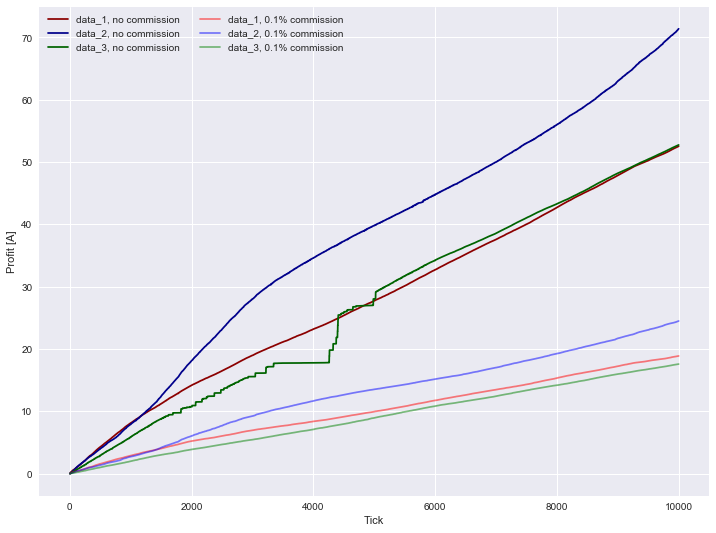

In [159]:
# plot results 
sns.set_style("darkgrid")
plt.figure(figsize=(12,9))
plt.plot(range(0, 10000), A1[0:10000], color = 'darkred',   label = 'data_1, no commission')
plt.plot(range(0, 10000), A2[0:10000], color = 'darkblue',  label = 'data_2, no commission')
plt.plot(range(0, 10000), A3[0:10000], color = 'darkgreen', label = 'data_3, no commission')
plt.plot(range(0, 10000), A1_commission[0:10000], color = 'red',   label = 'data_1, 0.1% commission', alpha = 0.5)
plt.plot(range(0, 10000), A2_commission[0:10000], color = 'blue',  label = 'data_2, 0.1% commission', alpha = 0.5)
plt.plot(range(0, 10000), A3_commission[0:10000], color = 'green', label = 'data_3, 0.1% commission', alpha = 0.5)
plt.legend(ncol=2, loc = 'upper left')
plt.xlabel("Tick")
plt.ylabel("Profit [A]")
plt.show()

В результате получаем прибыли:
    
    на данных data1 - 53 без комиссии и 19 с комиссией
    на данных data2 - 71 без комиссии и 25 с комиссией
    на данных data3 - 53 без комиссии и 18 с комиссией

In [169]:
# trading simulation v2 (no commission)

#  добаляем функцию  make_future_deal
#  она будет совершать часть сделки на текущем тике и возвращать информацию о том 
#  какую часть сделки и в каком объёме предполагается закончить на следующем тике

def make_future_deal(deal_path, deal_volume):

    p = np.copy(profit_table)

    i = 0
    V = deal_volume
    while i < len(deal_path) - 1:
        x = deal_path[i]
        y = deal_path[i+1]
        
        V = min(V, limits_table[x, y])
        limits_table[x, y] = limits_table[x, y] - V
        limits_table[y, x] = limits_table[x, y] * prices_table[x, y] 
        profit_table[x] = profit_table[x] - V 
        V = V * prices_table[x, y]
        profit_table[y] = profit_table[y] + V
        i = i + 1
        
    d = np.subtract(profit_table , p)

    future_deals_list = []
    d = list(d)
    for x in d:
        if x > 0.0:
            future_volume = x
            future_path = deal_path[deal_path.index((d.index(x))) : ]
            v = future_path, future_volume 
            future_deals_list.append(v)
            
    return future_deals_list

# ещё одно "улучшение", которое практичесски ничего не меняет
# продаём остатки валют B, C, D не просто по пути X -> A, а по оптимальному пути 
def optimal_sell(x):
    deals_stack = []
    
    if x == 1:
        # 1 - 0
        p = 1 * prices_table[1, 0] 
        v = ([1, 0] , p)
        deals_stack.append(v)
        # 1 - 2 - 0
        p = 1 * prices_table[1, 2] * prices_table[2, 0]
        v = ([1, 2, 0] , p)
        deals_stack.append(v)
        # 1 - 3 - 0
        p = 1 * prices_table[1, 3] * prices_table[3, 0]
        v = ([1, 3, 0] , p)
        deals_stack.append(v)
        # 1 - 2 - 3 - 0
        p = 1 * prices_table[1, 2] * prices_table[2, 3] * prices_table[3, 0]
        v = ([1, 2, 3, 0] , p)
        deals_stack.append(v)
        # 1 - 3 - 2 - 0
        p = 1 * prices_table[1, 3] * prices_table[3, 2] * prices_table[2, 0]
        v = ([1, 3, 2, 0] , p)
        deals_stack.append(v)
    
    elif x == 2:
        # 2 - 0
        p = 1 * prices_table[2, 0] 
        v = ([2, 0] , p)
        deals_stack.append(v)
        # 2 - 1 - 0
        p = 1 * prices_table[2, 1] * prices_table[1, 0]
        v = ([2, 1, 0] , p)
        deals_stack.append(v)
        # 2 - 3 - 0
        p = 1 * prices_table[2, 3] * prices_table[3, 0]
        v = ([2, 3, 0] , p)
        deals_stack.append(v)
        # 2 - 1 - 3 - 0
        p = 1 * prices_table[2, 1] * prices_table[1, 3] * prices_table[3, 0]
        v = ([2, 1, 3, 0] , p) 
        deals_stack.append(v)
        # 2 - 3 - 1 - 0
        p = 1 * prices_table[2, 3] * prices_table[3, 1] * prices_table[1, 0]
        v =([2, 3, 1, 0] , p)
        deals_stack.append(v)
    
    elif x == 3:
        # 3 - 0
        p = 1 * prices_table[3, 0] 
        v = ([3, 0] , p)
        deals_stack.append(v)
        # 3 - 1 - 0
        p = 1 * prices_table[3, 1] * prices_table[1, 0]
        v = ([3, 1, 0] , p)
        deals_stack.append(v)
        # 3 - 2 - 0
        p = 1 * prices_table[3, 2] * prices_table[2, 0]
        v = ([3, 2, 0] , p)
        deals_stack.append(v)
        # 3 - 1 - 2 - 0
        p = 1 * prices_table[3, 1] * prices_table[1, 2] * prices_table[2, 0]
        v = ([3, 1, 2, 0] , p)
        deals_stack.append(v)
        # 3 - 2 - 1 - 0
        p = 1 * prices_table[3, 2] * prices_table[2, 1] * prices_table[1, 0]
        v = ([3, 2, 1, 0] , p)
        deals_stack.append(v)
    
    else:
        return None
    
    deals_stack.sort(key=itemgetter(1))
    
    for path in deals_stack:
        make_deal(path[0], profit_table[x])

# если сделка в итоге окажется отрицательной, нужно будет это компенсировать
# покупкой A -> X
def buy(x):
        make_deal([0, x], abs(profit_table[x])*prices_table[x, 0])

prices_table = np.zeros((4,4))
limits_table = np.zeros((4,4))
profit_table = np.zeros(4)

deals_stack = []

unused_limits = [0, 0, 0, 0, 0, 0]
A = []
t = 0
while (t < 10000 ):
    
    set_prices_limits()
    reset_profit_table()
    calc_profit_table()
    best = best_deal()
    
    if profit_deals[best][1] > 0.0:
        top_deal = list(best)
        top_deal_volume = profit_deals[best][0]
    
    for d in deals_stack:
        make_deal(d[0], d[1])
    
    for x in range(1,4):
        if profit_table[x] < 0.0:
            buy(x)
    
    for x in range(1,4):
        if profit_table[x] > 0.0:
            optimal_sell(x)
            
    reset_profit_table()
    calc_profit_table()
    best = best_deal()   
    while best != None:
        make_deal(best, profit_deals[best][0])
        reset_profit_table()
        calc_profit_table()
        best = best_deal()
    
    deals_stack = make_future_deal(top_deal, top_deal_volume)
       
    A.append(profit_table[0])
    
 
    unused_limits[0] = unused_limits[0] + limits_table[0,1]
    unused_limits[1] = unused_limits[1] + limits_table[0,2]
    unused_limits[2] = unused_limits[2] + limits_table[0,3]
    unused_limits[3] = unused_limits[3] + limits_table[1,2]
    unused_limits[4] = unused_limits[4] + limits_table[1,3]
    unused_limits[5] = unused_limits[5] + limits_table[2,3]
    
    t = t + 1
    
print("Final balance: ")
print(round(profit_table[0], 2))
print(round(profit_table[1], 2))
print(round(profit_table[2], 2))
print(round(profit_table[3], 2))
print("Unused limits: ", unused_limits)

Final balance: 
45.28
0.0
0.0
0.0
Unused limits:  [4366.1955460973377, 1549.6310433093888, 2955.5207717813305, 3494.4591422958601, 3800.5531817552724, 1594.5020924444532]


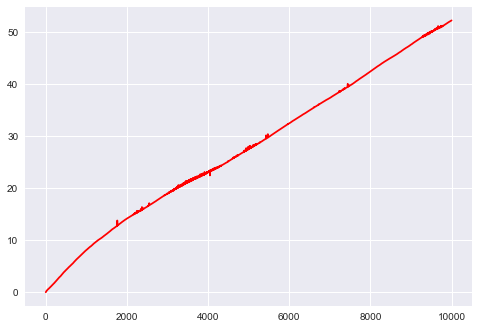

In [165]:
plt.plot(range(10000), A[0:10000], color = 'red')
plt.show()

на данных data1 - 53 без комиссии и 19 с комиссией;
на данных data2 - 71 без комиссии и 25 с комиссией;
на данных data3 - 53 без комиссии и 18 с комиссией;